In [ ]:
!pip install -U lightautoml

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task
from lightautoml.validation.np_iterators import TimeSeriesIterator

from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error

import os

COMMON_PATH = os.path.dirname(os.getcwd())
PATH =  os.path.join(COMMON_PATH, r'data\train_datasets')
#SAVE_PATH = os.path.join(os.getcwd(), r'ML_models')

D:\conda\envs\new_env\lib\site-packages\dask\dataframe\_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(


'nlp' extra dependecy package 'gensim' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependecy package 'transformers' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependecy package 'gensim' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependecy package 'transformers' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.


D:\conda\envs\new_env\lib\site-packages\lightautoml\ml_algo\dl_model.py:42: UserWarning: 'transformers' - package isn't installed
  warnings.warn("'transformers' - package isn't installed")
D:\conda\envs\new_env\lib\site-packages\lightautoml\text\embed.py:22: UserWarning: 'transformers' - package isn't installed
  warnings.warn("'transformers' - package isn't installed")
D:\conda\envs\new_env\lib\site-packages\lightautoml\text\dl_transformers.py:25: UserWarning: 'transformers' - package isn't installed
  warnings.warn("'transformers' - package isn't installed")


# Reading files

In this file one can see our early experiments with forecasting for one particular stock chosen randomly. Later there will be a special scikit-learn-like pipeline that generalize our framework.

In [2]:
ticker_names = [name[:-4] for name in os.listdir(os.path.join(COMMON_PATH, r'data\fintech'))]

fintech_train = pd.read_csv(os.path.join(PATH, 'fintech_train.csv'))
fintech_test = pd.read_csv(os.path.join(PATH, 'fintech_test.csv'))
fintech_train['date'] = pd.to_datetime(fintech_train['date'])
fintech_test['date'] = pd.to_datetime(fintech_test['date'])

existing_tickets = [col[6:] for col in fintech_train.columns if 'close' in col]
ticker_names = list(set(ticker_names).intersection(set(existing_tickets)))

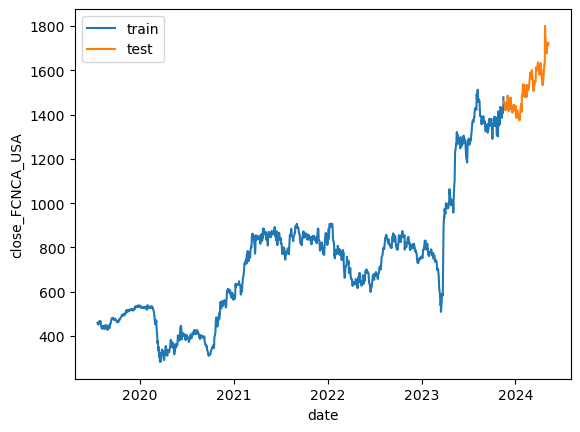

In [3]:
ticker = 'FCNCA_USA'
sns.lineplot(fintech_train, x = 'date', y = f'close_{ticker}', label = 'train')
sns.lineplot(fintech_test, x= 'date', y = f'close_{ticker}', label = 'test')
plt.legend();

# Bechmark

As a bechmark we use simple linear regression trained on all numerical features. Boostings (XGBoost, CatBoost), SSA and even LightAutoML (boostings + stacking) were tried but they did not overcome linear model. 

MSE: 812.5818451802578
MAE 20.646539845577305
MAPE: 0.013485447511706054


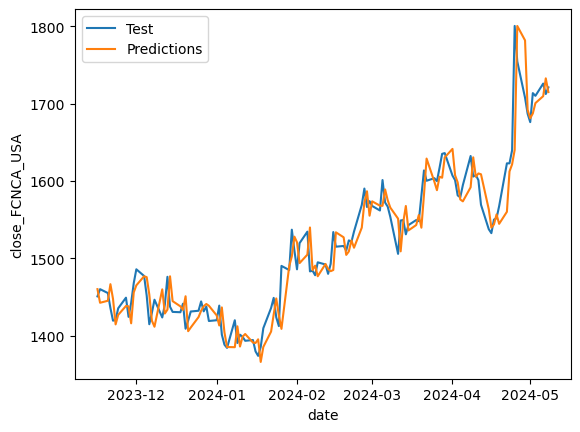

In [83]:
from sklearn.linear_model import LinearRegression

x_train = fintech_train[[col for col in fintech_train.columns if ticker in col]].drop(
    [f'volume_{ticker}', f'close_{ticker}'], axis = 1
).select_dtypes('number')
y_train = fintech_train[f'close_{ticker}']

x_test = fintech_test[[col for col in fintech_train.columns if ticker in col]].drop(
    [f'volume_{ticker}', f'close_{ticker}'], axis = 1
).select_dtypes('number')
y_test = fintech_test[f'close_{ticker}'] 

reg = LinearRegression().fit(x_train, y_train)
predictions = reg.predict(x_test)

sns.lineplot(fintech_test, x = 'date', y = f'close_{ticker}', label = 'Test')
sns.lineplot(fintech_test, x = 'date', y = predictions, label = 'Predictions')
print('MSE:', mean_squared_error(y_test, predictions))
print('MAE', mean_absolute_error(y_test, predictions))
print('MAPE:', mean_absolute_percentage_error(y_test, predictions))
plt.legend();

As you see, linear model is tend to predict $f_t$ as $f_{t-1}$ so it can be named a naive approach.  

## LightAutoML example

LightAutoML is a general framework that does fitting model, tuning hyperparameters and blending. By default it uses linear model and boostings to get final predictions. More about AutoML one can [read here](https://github.com/sberbank-ai-lab/LightAutoML).

In [2]:
def train_tickers(x_train, ticker, ticker_names, cols_to_drop = [], time = 60**4):

    target = f'close_{ticker}'
    volumes_to_drop = [f'volume_{name}' for name in ticker_names]
    cols_to_drop += volumes_to_drop + ['close_S&P500', 'volume_S&P500', 
                                      'Close_IMOEX', 'Volume_IMOEX',
                                     'gold_rates', 'silver_rates',
                                      'platinum_rates', 'palladium_rates',
                                      'day_of_week','gap_hl_S&P500',
                                      'gap_co_S&P500', 'gap_hl_IMOEX',
                                      'gap_co_IMOEX']

    
    cv_iterator = TimeSeriesIterator(
                    datetime_col=x_train['date'],  # столбец с временными метками
                    n_splits=3,           # количество фолдов
                )
    automl = TabularAutoML(
        task = Task(
            name = 'reg'
           ),
        timeout = time,
        general_params = {'use_algos': 'auto'},
        reader_params = {'cv_iter': cv_iterator}
    )
    predictions = automl.fit_predict(
        x_train,
        roles = {'target': target, 'drop': cols_to_drop},
        verbose = 3,
    )

    return automl

In [28]:
automl = train_tickers(fintech_train, ticker, ticker_names, time = 600)

[21:23:57] Stdout logging level is INFO3.
[21:23:57] Task: reg

[21:23:57] Start automl preset with listed constraints:
[21:23:57] - time: 600.00 seconds
[21:23:57] - CPU: 4 cores
[21:23:57] - memory: 16 GB

[21:23:57] Train data shape: (1129, 12852)

[21:26:21] Feats was rejected during automatic roles guess: []
[21:26:25] Layer 1 train process start. Time left 451.53 secs
[21:27:32] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[21:27:32] ===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
[21:27:35] Linear model: C = 1e-05 score = -795.037893008797
[21:27:37] Linear model: C = 5e-05 score = -404.53878941409334
[21:27:40] Linear model: C = 0.0001 score = -336.9980906349208
[21:27:42] Linear model: C = 0.0005 score = -276.6190640198373
[21:27:45] Linear model: C = 0.001 score = -269.13818844505874
[21:27:49] Linear model: C = 0.005 score = -263.51709905775846
[21:27:51] Linear model: C = 0.01 score = -262.8438783766439
[21:27:53] Linear model: C = 0.05 score = -262.3

In [29]:
predictions = automl.predict(fintech_test)

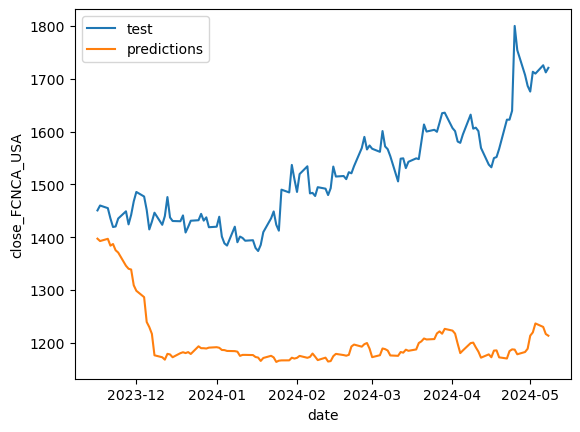

In [30]:
sns.lineplot(fintech_test, x= 'date', y = f'close_{ticker}', label = 'test')
sns.lineplot(fintech_test, x= 'date', y = predictions.data[:,0], label = 'predictions')
plt.legend();

<Axes: xlabel='Feature'>

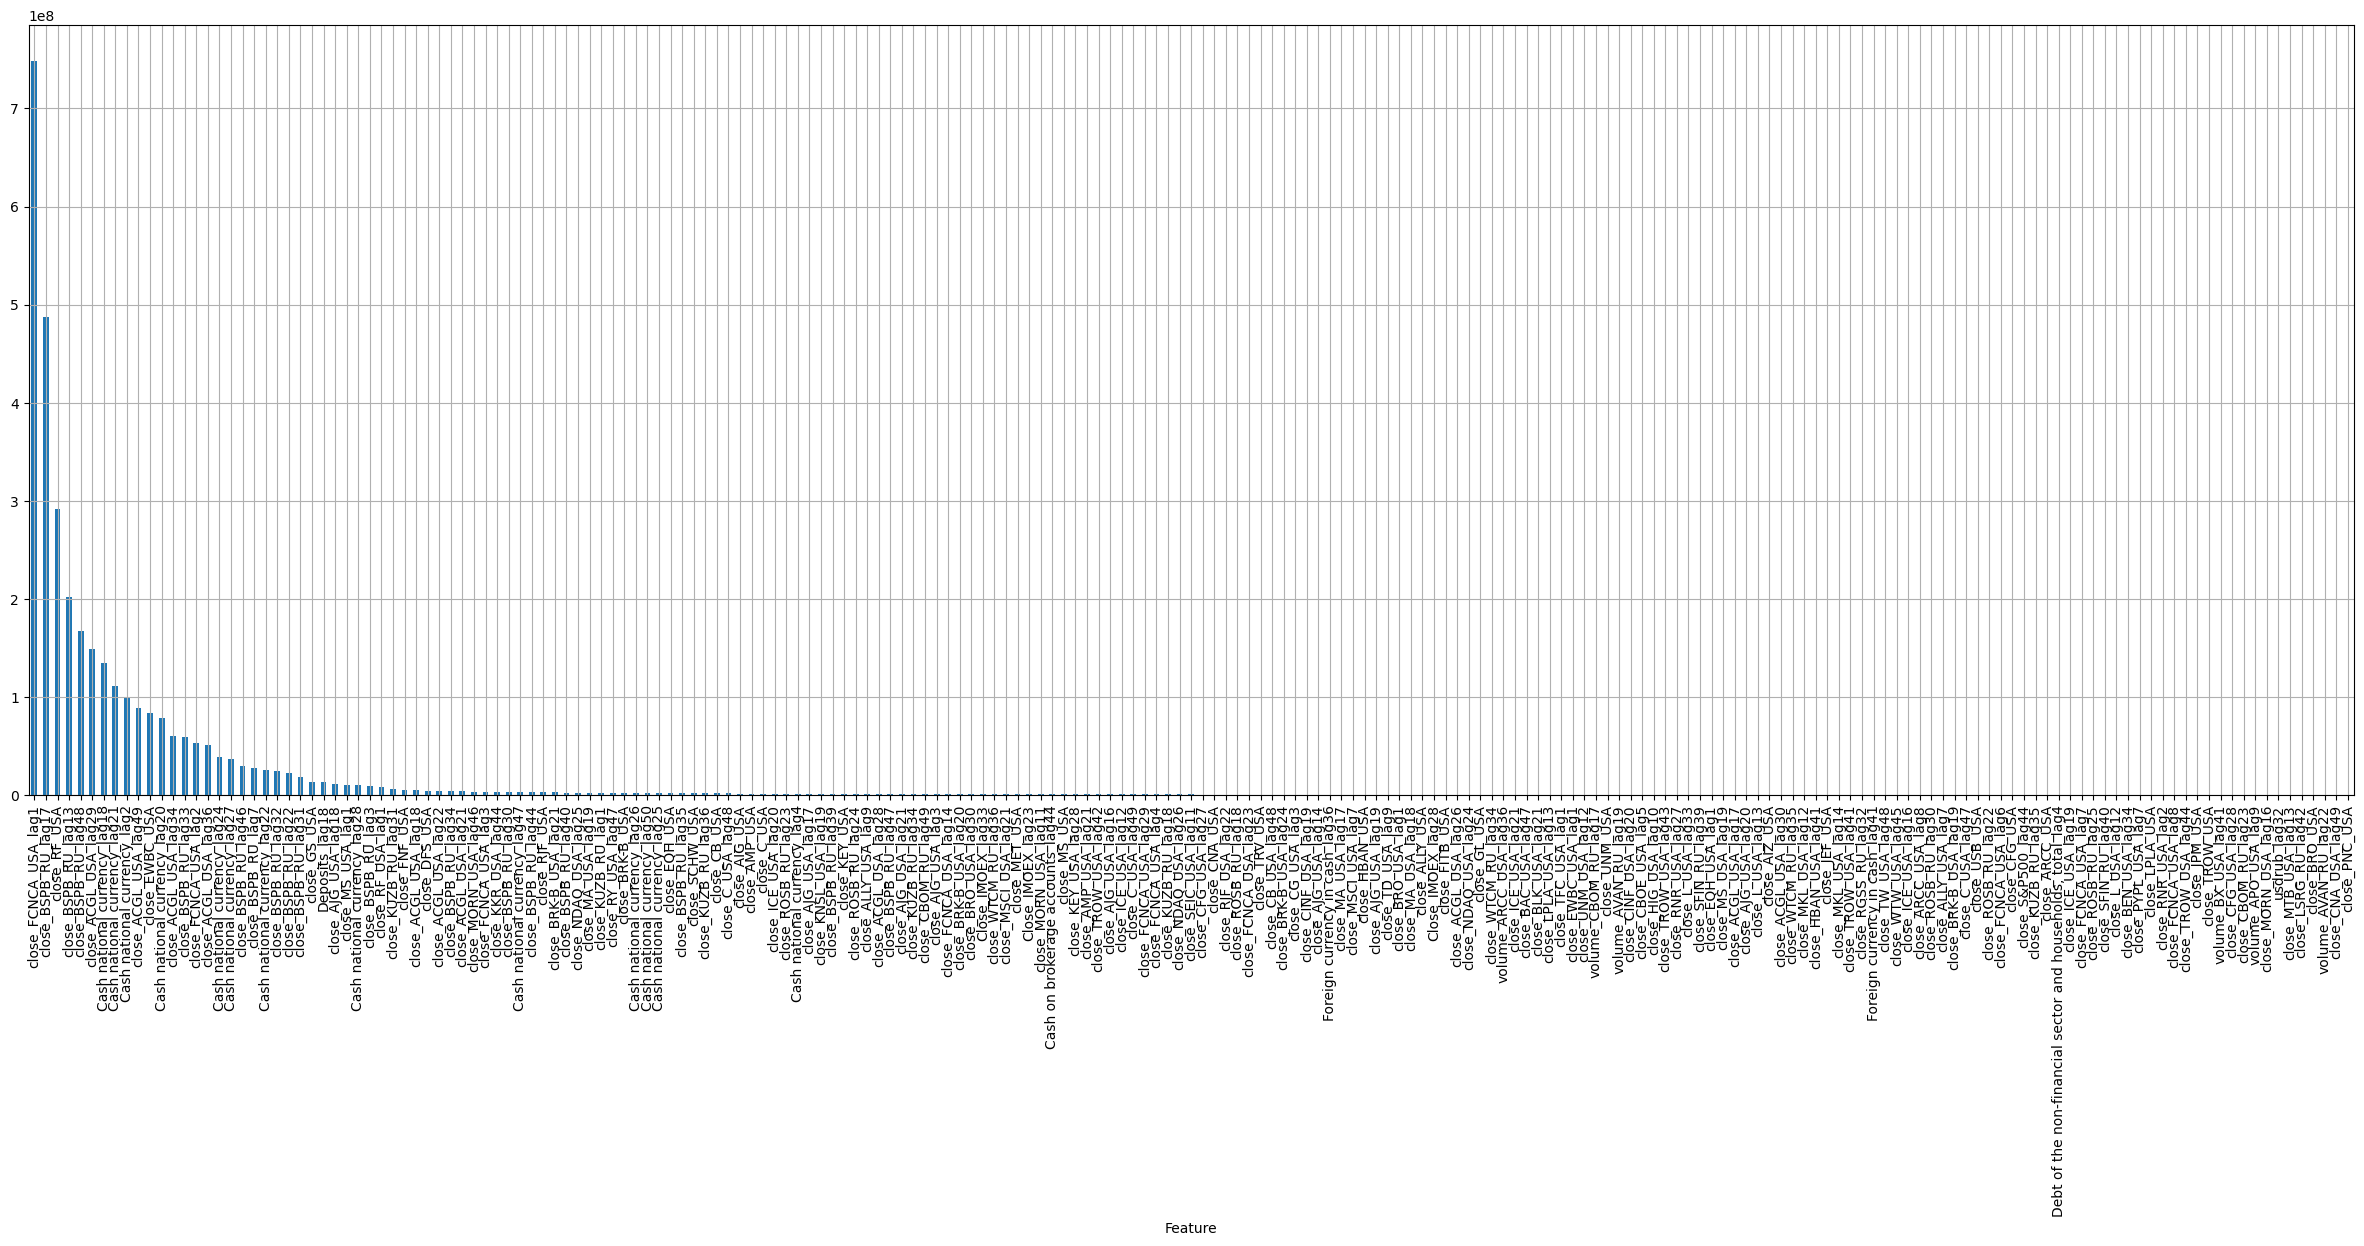

In [36]:
fast_fi = automl.get_feature_scores('fast')
fast_fi.loc[:200,].set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)

In [51]:
# Pop out all columns with zero importance 
cols_to_drop = list(fast_fi[fast_fi['Importance'] == 0]['Feature'])
automl = train_tickers(fintech_train, ticker, ticker_names, cols_to_drop = cols_to_drop, time = 3600)

[10:29:56] Stdout logging level is INFO.
[10:29:56] Task: reg

[10:29:56] Start automl preset with listed constraints:
[10:29:56] - time: 3600.00 seconds
[10:29:56] - CPU: 4 cores
[10:29:56] - memory: 16 GB

[10:29:56] Train data shape: (1129, 12852)

[10:32:11] Layer 1 train process start. Time left 3465.01 secs
[10:32:51] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[10:33:47] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -422.4919042837484
[10:33:47] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[10:33:47] Time left 3368.76 secs

[10:38:37] Selector_LightGBM fitting and predicting completed
[10:38:47] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[10:48:16] Time limit exceeded after calculating fold 1

[10:48:16] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -380.63564695195544
[10:48:16] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[10:48:18] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...
[10:56:54] Time limit exceeded after calculatin

In [54]:
predictions = automl.predict(fintech_test)

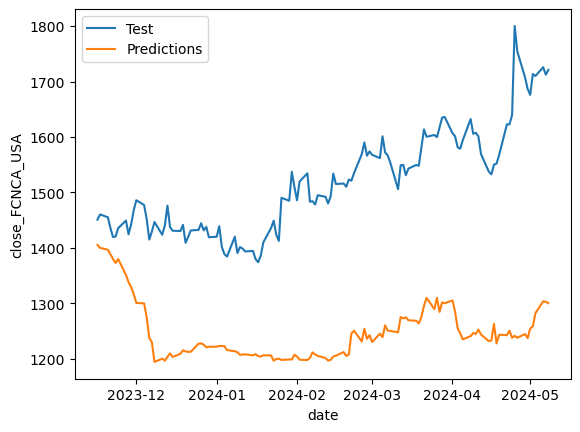

In [55]:
sns.lineplot(fintech_test, x= 'date', y = f'close_{ticker}', label = 'Test')
sns.lineplot(fintech_test, x= 'date', y = predictions.data[:,0], label = 'Predictions')
plt.legend();

Feature removal has no effect on result. In general, GBDT and all tree-based models have unaccurate predictions.  

# Feature engineering

As tree-based models give predictions with high MSE, we can not use them to evalute feature importance. The only model that can be applied is a linear regression. Thus, we made Lasso Regression and remove all features with zero coefficients. Before training one-hot-encoding for categorical features and PCA for numerical ones were done. 

In [9]:
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso

def columns_to_drop(df, target_ticker, ticker_names):
    dates = [col for col in df.columns if 'date' in col]
    volumes_to_drop = [f'volume_{name}' for name in ticker_names]
    prices_to_drop = [f'close_{name}' for name in ticker_names]
    cols_to_drop = dates + volumes_to_drop + prices_to_drop + ['close_S&P500', 'volume_S&P500', 
                                      'Close_IMOEX', 'Volume_IMOEX',
                                     'gold_rates', 'silver_rates',
                                      'platinum_rates', 'palladium_rates',
                                      'day_of_week','gap_hl_S&P500',
                                      'gap_co_S&P500', 'gap_hl_IMOEX',
                                      'gap_co_IMOEX']
    return cols_to_drop

def extract_feature_importance(x_train, x_test, target_ticker, ticker_names):

    target = f'close_{target_ticker}'
    cols_to_drop = columns_to_drop(x_train, target_ticker, ticker_names) 
    
    y_train, x_train = x_train[target], x_train.drop(cols_to_drop, axis = 1)
    x_test = x_test.drop(cols_to_drop, axis = 1)
    cat_features = x_train.select_dtypes('object').columns

    scaler = MinMaxScaler()
    decomposer = PCA(n_components = 0.99)
    x_train_num = scaler.fit_transform(x_train.select_dtypes('number').astype('float32'))
    x_train_num = decomposer.fit_transform(x_train_num)
    x_train_cat = pd.get_dummies(x_train.select_dtypes('object'), cat_features, drop_first = True).astype('int16')
    x_train = pd.concat([pd.DataFrame(x_train_num, columns = [str(i) for i in range(1, x_train_num.shape[1]+1)]), 
                         x_train_cat], axis = 1) 
    
    x_test_num = scaler.transform(x_test.select_dtypes('number').astype('float32'))
    x_test_num = decomposer.transform(x_test_num)
    x_test_cat = pd.get_dummies(x_test.select_dtypes('object'), cat_features, drop_first = True).astype('int16')
    x_test = pd.concat([pd.DataFrame(x_test_num, columns = [str(i) for i in range(1, x_test_num.shape[1]+1)]), 
                         x_test_cat], axis = 1)
    
    regressor = Lasso(alpha = 1)
    regressor.fit(x_train, y_train)
    feature_importance = np.abs(regressor.coef_) / np.abs(regressor.coef_.sum())

    feature_names = x_train.columns.tolist()

    predictions = regressor.predict(x_test)
    return feature_importance, feature_names, predictions

In [10]:
ticker = 'FCNCA_USA'
feature_importances, feature_names, predictions = extract_feature_importance(fintech_train, fintech_test, ticker, ticker_names)

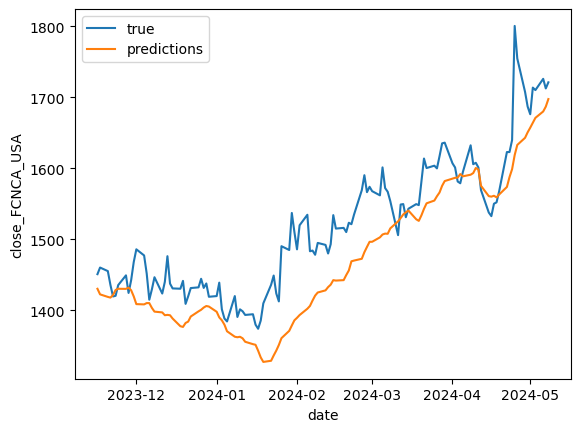

In [11]:
sns.lineplot(fintech_test, x = 'date', y = f'close_{ticker}', label = 'true')
sns.lineplot(fintech_test, x = 'date', y = predictions, label = 'predictions')
plt.legend();

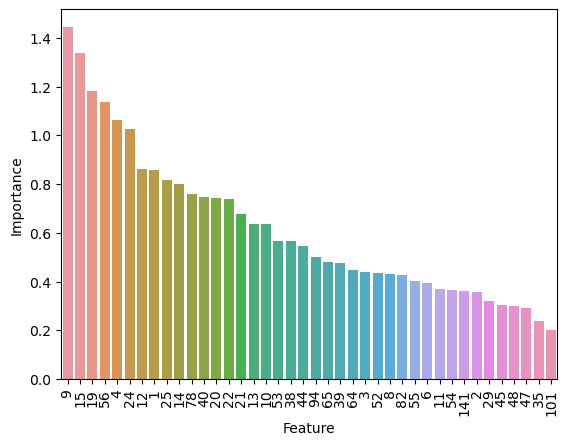

In [12]:
# Among top-40 features all are numerical ones

sorted_indx = np.argsort(feature_importances)[::-1]
sns.barplot(x = np.array(feature_names)[sorted_indx[:40]], y = feature_importances[sorted_indx[:40]])
plt.xticks(rotation = 90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show();

766 features has zero weight


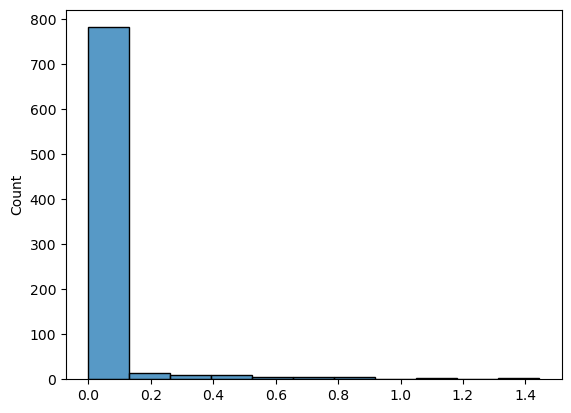

In [13]:
# Most features have zero importance (almost all categorical)

sns.histplot(feature_importances)
print(sum(feature_importances == 0), 'features has zero weight')

# Tuning linear model

ElasticNet was tuned with optuna (100 iterations) with all feature engineering that was done before. 

In [31]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import ElasticNet
import optuna
features_to_drop = np.array(feature_names)[feature_importances == 0]

def optimize(trial):
    target = f'close_{target_ticker}'
    x_train, x_test = fintech_train, fintech_test

    cols_to_drop = columns_to_drop(x_train, target_ticker, ticker_names)
    y_train, x_train = x_train[target], x_train.drop(cols_to_drop, axis = 1)
    y_test, x_test = x_test[target], x_test.drop(cols_to_drop, axis = 1)
    cat_features = x_train.select_dtypes('object').columns

    scaler = MinMaxScaler()
    decomposer = PCA(n_components = 0.99)
    x_train_num = scaler.fit_transform(x_train.select_dtypes('number').astype('float32'))
    x_train_num = decomposer.fit_transform(x_train_num)
    x_train_cat = pd.get_dummies(x_train.select_dtypes('object'), cat_features, drop_first = True).astype('int16')
    x_train = pd.concat([pd.DataFrame(x_train_num, columns = [str(i) for i in range(1, x_train_num.shape[1]+1)]), 
                         x_train_cat], axis = 1) 
    x_train = x_train.drop(features_to_drop, axis = 1)
    
    x_test_num = scaler.transform(x_test.select_dtypes('number').astype('float32'))
    x_test_num = decomposer.transform(x_test_num)
    x_test_cat = pd.get_dummies(x_test.select_dtypes('object'), cat_features, drop_first = True).astype('int16')
    x_test = pd.concat([pd.DataFrame(x_test_num, columns = [str(i) for i in range(1, x_test_num.shape[1]+1)]), 
                         x_test_cat], axis = 1)
    x_test = x_test.drop(features_to_drop, axis = 1)

    
    regressor = ElasticNet(alpha = trial.suggest_float('alpha', 0.1,10), 
                          l1_ratio = trial.suggest_float('l1_ratio', 0.1,1))
    regressor.fit(x_train, y_train)

    predictions = regressor.predict(x_test)

    return mean_squared_error(predictions, y_test)
    

In [32]:
target_ticker = ticker
study = optuna.create_study(direction = 'minimize')
study.optimize(optimize, n_trials=100, show_progress_bar=True)
print(study.best_params)

[I 2024-06-02 16:29:26,928] A new study created in memory with name: no-name-5d6eb090-b48f-48ff-a2d6-c45c2cc8088a


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2024-06-02 16:29:33,997] Trial 0 finished with value: 1903.2577663447723 and parameters: {'alpha': 4.404265918718117, 'l1_ratio': 0.48070069098559376}. Best is trial 0 with value: 1903.2577663447723.
[I 2024-06-02 16:29:41,138] Trial 1 finished with value: 1810.725607977663 and parameters: {'alpha': 1.5678282114800113, 'l1_ratio': 0.4384696853225303}. Best is trial 1 with value: 1810.725607977663.
[I 2024-06-02 16:29:48,653] Trial 2 finished with value: 2008.2581367898526 and parameters: {'alpha': 6.548152280870132, 'l1_ratio': 0.9023478806978099}. Best is trial 1 with value: 1810.725607977663.
[I 2024-06-02 16:29:55,405] Trial 3 finished with value: 3875.825416097592 and parameters: {'alpha': 9.751502483581234, 'l1_ratio': 0.36649884591620463}. Best is trial 1 with value: 1810.725607977663.
[I 2024-06-02 16:30:02,488] Trial 4 finished with value: 1870.7845169189623 and parameters: {'alpha': 4.442027588810803, 'l1_ratio': 0.5855054950947539}. Best is trial 1 with value: 1810.7256079

0.02108153027167657


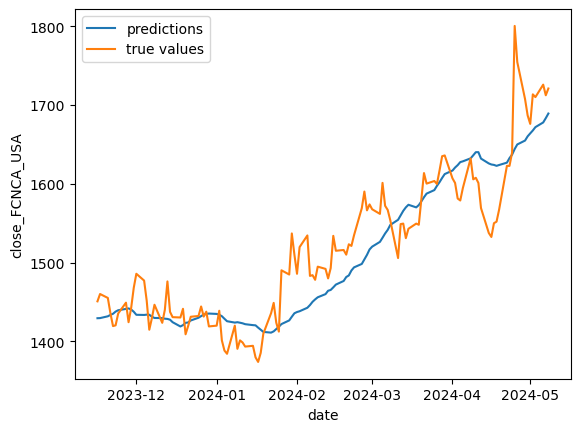

In [35]:
target = f'close_{target_ticker}'
x_train, x_test = fintech_train, fintech_test

cols_to_drop = columns_to_drop(x_train, target_ticker, ticker_names)
y_train, x_train = x_train[target], x_train.drop(cols_to_drop, axis = 1)
y_test, x_test = x_test[target], x_test.drop(cols_to_drop, axis = 1)
cat_features = x_train.select_dtypes('object').columns

scaler = MinMaxScaler()
decomposer = PCA(n_components = 0.99)
x_train_num = scaler.fit_transform(x_train.select_dtypes('number').astype('float32'))
x_train_num = decomposer.fit_transform(x_train_num)
x_train_cat = pd.get_dummies(x_train.select_dtypes('object'), cat_features, drop_first = True).astype('int16')
x_train = pd.concat([pd.DataFrame(x_train_num, columns = [str(i) for i in range(1, x_train_num.shape[1]+1)]), 
                     x_train_cat], axis = 1) 
x_train = x_train.drop(features_to_drop, axis = 1)

x_test_num = scaler.transform(x_test.select_dtypes('number').astype('float32'))
x_test_num = decomposer.transform(x_test_num)
x_test_cat = pd.get_dummies(x_test.select_dtypes('object'), cat_features, drop_first = True).astype('int16')
x_test = pd.concat([pd.DataFrame(x_test_num, columns = [str(i) for i in range(1, x_test_num.shape[1]+1)]), 
                     x_test_cat], axis = 1)
x_test = x_test.drop(features_to_drop, axis = 1)

regressor = ElasticNet(**study.best_params)
regressor.fit(x_train, y_train)

predictions = regressor.predict(x_test)

sns.lineplot(fintech_test, x = 'date', y = predictions, label = 'predictions')
sns.lineplot(fintech_test, x = 'date', y = f'close_{ticker}', label = 'true values')
plt.legend()
print(mean_absolute_percentage_error(fintech_test[f'close_{ticker}'], predictions))
np.save('predictions_Linear', predictions)

# AutoARIMA

Arima is a another linear model used in final predictions. It differs in style of training that uses only price history for a particular stock. 

In [101]:
import pmdarima as pm

ts_train = fintech_train[f'close_{ticker}']
ts_test = fintech_test[f'close_{ticker}']

def arima_1step_predictions(ts_train, ts_test):

    predictions = []
    for step in range(len(ts_test)):
        if step > 0:
            ts_train_new = np.concatenate([ts_train, ts_test[:step]])
        else: 
            ts_train_new = ts_train
        model = pm.auto_arima(ts_train_new, seasonal = True)
        prediction = model.predict(1)
    
        predictions.append(prediction)
    
    return np.array(predictions)[:,0]

0.012493295815495704


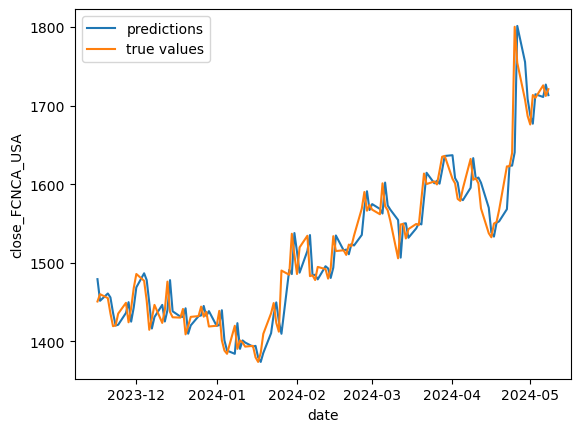

In [102]:
predictions = arima_1step_predictions(ts_train, ts_test)

sns.lineplot(fintech_test, x = 'date', y = predictions, label = 'predictions')
sns.lineplot(fintech_test, x = 'date', y = f'close_{ticker}', label = 'true values')
plt.legend()
print(mean_absolute_percentage_error(ts_test, predictions))
np.save('predictions_ARIMA', predictions)

One can notice that ARIMA has the same problem as linear model - it forecast $f_{t-1}$ to $f_{t}$, but we consider this model more robust as it traines only on price history.